In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
# Funzione per contare i set vinti
def conta_set_vinti(score, player):
    set_vinti = 0
    for set_score in score.split():
        set_p1, set_p2 = map(int, set_score.split('-'))
        if (set_p1 > set_p2 and player == 1) or (set_p2 > set_p1 and player == 2):
            set_vinti += 1
    return set_vinti

In [15]:
# Definizione delle feature base
winner_features = [
    'Rank_1', 'Rank_2',
    'Pts_1', 'Pts_2',
    'Odd_1', 'Odd_2',
    'rank_diff',  # manteniamo solo questa tra le feature derivate dal rank   
    'Odd_diff'
]

# Carica il dataset
print("Caricamento del dataset...")
df = pd.read_csv('Datasets/atp_tennis.csv')

print("\nPrima del filtraggio:")
print(f"Righe totali: {len(df)}")

# Filtra le quote negative o nulle
df = df[(df['Odd_1'] > 0) & (df['Odd_2'] > 0)]
# Filtra i punti positivi
df = df[(df['Pts_1'] > 0) & (df['Pts_2'] > 0)]

print("\nDopo il filtraggio:")
print(f"Righe rimanenti: {len(df)}")

# Calcola le feature derivate
df['rank_diff'] = df['Rank_1'] - df['Rank_2']
df['rank_ratio'] = df['Rank_1'] / df['Rank_2']
df['pts_ratio'] = df['Pts_1'] / df['Pts_2']
df['avg_rank'] = (df['Rank_1'] + df['Rank_2']) / 2
df['total_pts'] = df['Pts_1'] + df['Pts_2']
df['Odd_diff'] = df['Odd_1'] - df['Odd_2']  # Aggiungi questa riga



df['target'] = df.apply(lambda row: 1 if row['Winner'].strip() == row['Player_1'].strip() else 0, axis=1)


Caricamento del dataset...

Prima del filtraggio:
Righe totali: 64166

Dopo il filtraggio:
Righe rimanenti: 48344


In [16]:
# Modifica della variabile target
print("Preparazione del target...")

# Preparazione del dataset per l'addestramento
X = df[winner_features] # Manteniamo le stesse feature
y = df['target']  # Usiamo la nuova colonna target binaria

# Divisione train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifica della distribuzione del target
print("\nDistribuzione delle vittorie:")
print(f"Vittorie Player_1: {(y == 1).sum()}")
print(f"Vittorie Player_2: {(y == 0).sum()}")

# Scaling delle feature
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

# ... codice esistente ...

Preparazione del target...

Distribuzione delle vittorie:
Vittorie Player_1: 24169
Vittorie Player_2: 24175
(38675, 8)
(9669, 8)



--------------------------------------------------
Valutazione del classificatore: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68      4879
           1       0.67      0.67      0.67      4790

    accuracy                           0.67      9669
   macro avg       0.67      0.67      0.67      9669
weighted avg       0.67      0.67      0.67      9669



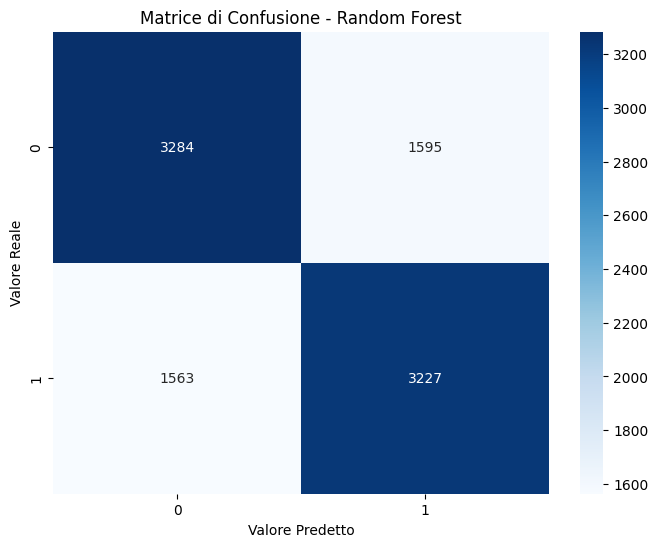

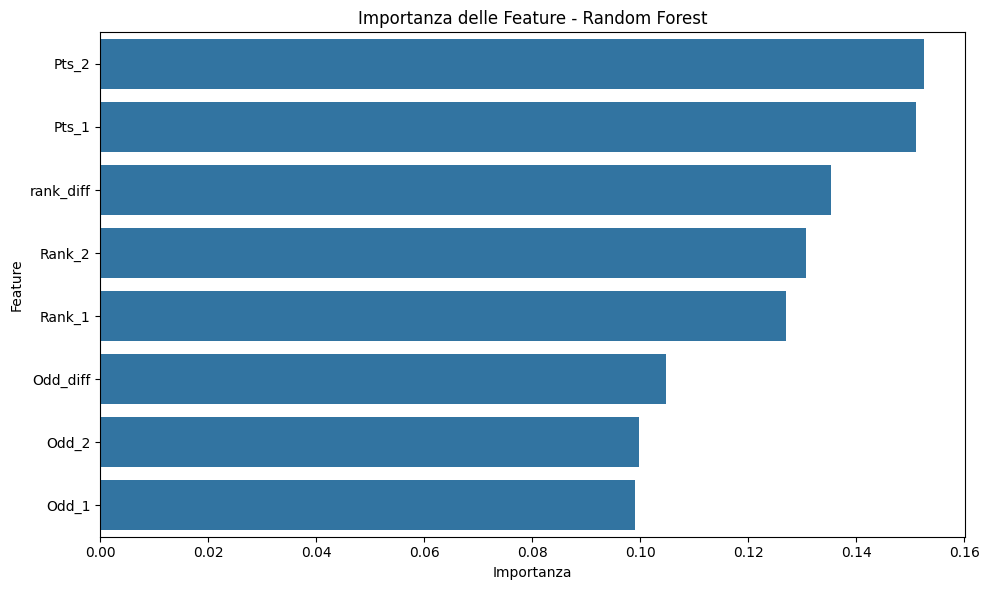


Importanza delle feature in percentuale:
Pts_2: 15.25%
Pts_1: 15.10%
rank_diff: 13.53%
Rank_2: 13.07%
Rank_1: 12.69%
Odd_diff: 10.48%
Odd_2: 9.98%
Odd_1: 9.90%

--------------------------------------------------
Valutazione del classificatore: SVM

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      4879
           1       0.69      0.70      0.70      4790

    accuracy                           0.70      9669
   macro avg       0.70      0.70      0.70      9669
weighted avg       0.70      0.70      0.70      9669



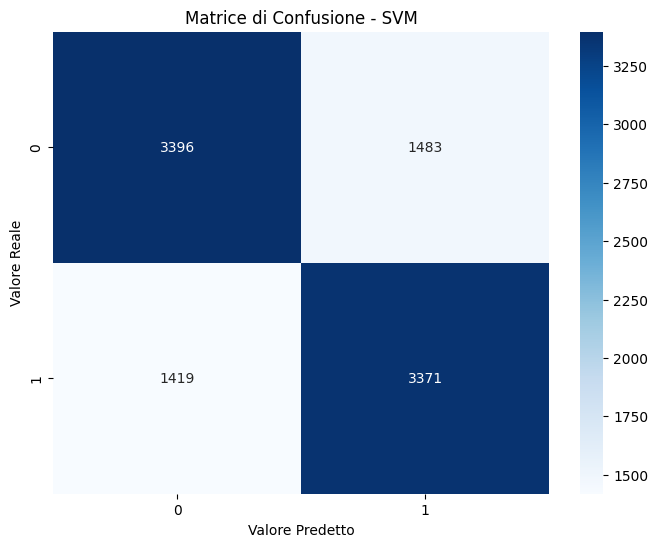


--------------------------------------------------
Valutazione del classificatore: Gradient Boosting

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      4879
           1       0.70      0.69      0.70      4790

    accuracy                           0.70      9669
   macro avg       0.70      0.70      0.70      9669
weighted avg       0.70      0.70      0.70      9669



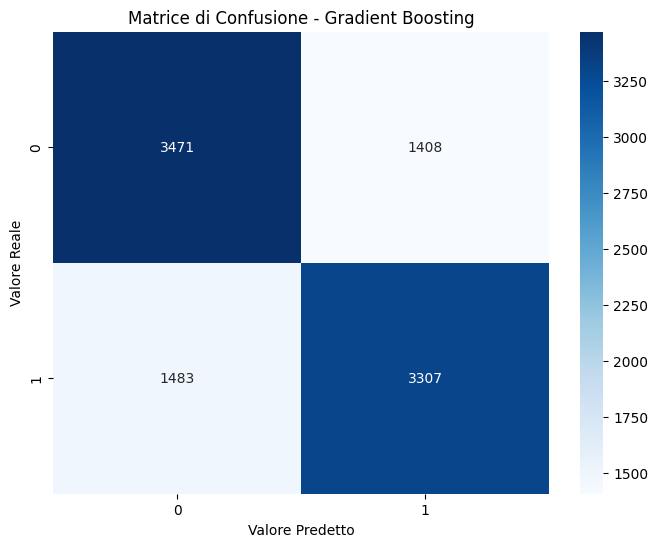

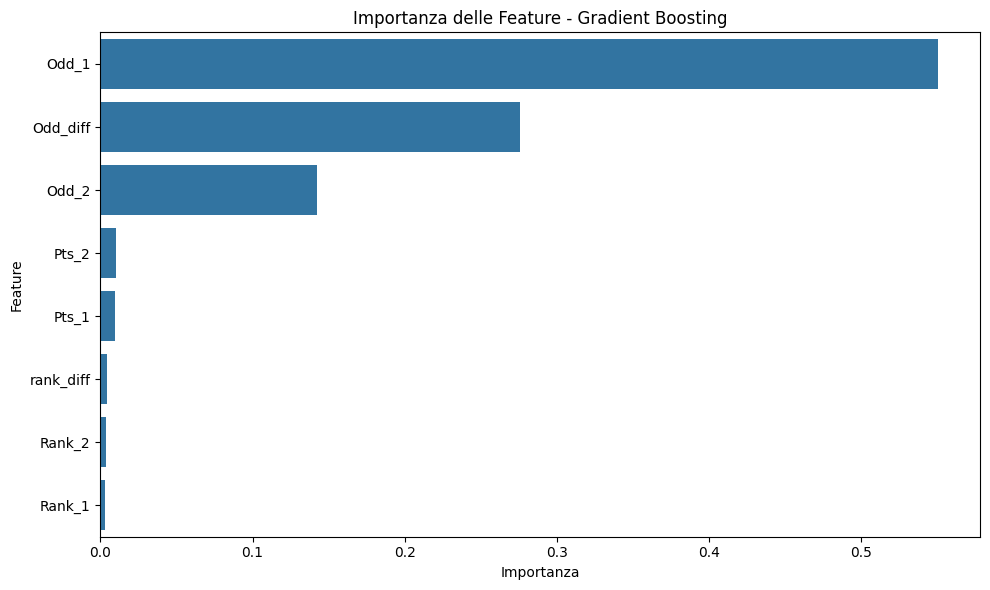


Importanza delle feature in percentuale:
Odd_1: 55.03%
Odd_diff: 27.58%
Odd_2: 14.21%
Pts_2: 1.03%
Pts_1: 0.95%
rank_diff: 0.45%
Rank_2: 0.41%
Rank_1: 0.34%


In [17]:
# Dizionario dei classificatori
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', C=10.0, gamma='scale', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Valutazione dei modelli
results = {}

for name, clf in classifiers.items():
    print(f"\n{'-'*50}")
    print(f"Valutazione del classificatore: {name}")
    
    # Addestramento
    clf.fit(X_train, y_train)
    
    # Predizioni
    y_pred = clf.predict(X_test)
    
    # Salvataggio risultati
    results[name] = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Report di classificazione
    print("\nClassification Report:")
    print(results[name]['classification_report'])
    
    # Matrice di confusione
    plt.figure(figsize=(8, 6))
    cm = results[name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice di Confusione - {name}')
    plt.ylabel('Valore Reale')
    plt.xlabel('Valore Predetto')
    plt.show()

    # Feature importance per Random Forest e Gradient Boosting
    if name in ['Random Forest', 'Gradient Boosting']:
        feature_importance = pd.DataFrame({
            'feature': winner_features,
            'importance': clf.feature_importances_
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance)
        plt.title(f'Importanza delle Feature - {name}')
        plt.xlabel('Importanza')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
        
        print("\nImportanza delle feature in percentuale:")
        for idx, row in feature_importance.iterrows():
            print(f"{row['feature']}: {row['importance']*100:.2f}%")